# BTL3 môn Học Máy, mã môn học CO3117 - Học máy với dữ liệu hình ảnh
## **Thông tin nhóm**

+ **Tên nhóm** : MLP2
+ **Giảng viên hướng dẫn**: TS. Lê Thành Sách
+ **Thành viên** :

    | **MSSV** | **Họ và tên** |
    |:---|:---:|
    | 2312046 | Bùi Ngọc Minh |
    | 2313233 | Lê Trọng Thiện |


## **Dataset**
Dữ liệu cho collab này bao gồm 6862 hình ảnh về thời tiết. Bao gồm 11 loại:
+ sương (gồm 698 ảnh)
+ sương mù/khói bụi (gồm 851 ảnh)
+ sương giá (gồm 475 ảnh)
+ men (gồm 639 ảnh)
+ mưa đá (gồm 591 ảnh)
+ sét (gồm 377 ảnh)
+ mưa (gồm 526 ảnh)
+ cầu vồng (gồm 232 ảnh)
+ sương muối (gồm 1160 ảnh)
+ bão cát (gồm 692 ảnh)
+ tuyết (gồm 621 ảnh)

Dữ liệu này được lấy tại [kraggle](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset).

## **Nội dung**
File collab này áp dụng pipeline học máy truyền thống cho bộ dữ liệu.

# Correct Folders

In [1]:
%cd ..

/


# Imports

In [2]:
import os
import re
import time
import json
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.cuda.amp import autocast, GradScaler


from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input

# from modules.module import*
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [3]:
!pip install transformers timm

In [4]:
# Import transformer based image feature extractor
# We do 3 models here, Deit, Dinov2 and Swin
# Featuring different technniques
# These 3 should run fine in google collab

# Runtime : ~5s the first time, 1s every time onwards

# pre-processings
import timm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T = transforms
T = T.Compose([
    T.ToTensor(),
    T.Resize((224, 224), antialias=True),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Deit (Data-efficient Image Transformer)
# Vision Transformer with distillation token
# this has a tiny model but we will use the small one (for maybe better result)
deit_model = timm.create_model('deit_small_patch16_224', pretrained=True)
deit_model.reset_classifier(0)  # remove head for feature extraction

deit_model = deit_model.to(device).eval()
print("Deit imported")

# Dinov2
# ViT backbone, trained self-supervised
# Pretrained weights from facebook
from transformers import AutoImageProcessor, AutoModel
dinov2_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
dinov2_model = AutoModel.from_pretrained("facebook/dinov2-small")

print("Dinov2 imported")

# Swin tiny
# Windowed attention
swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
swin_model.reset_classifier(0)
swin_model = swin_model.to(device).eval()

print("Swin imported")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Deit imported


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Dinov2 imported


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Swin imported


# Fetching data

In [5]:
img_shape= (300,300,3)  # Kích thước ảnh đầu vào

In [6]:
import kagglehub
data_path=kagglehub.dataset_download(handle="jehanbhathena/weather-dataset")+"/dataset"

Using Colab cache for faster access to the 'weather-dataset' dataset.


In [7]:
os.listdir(data_path)

['hail',
 'rainbow',
 'frost',
 'rime',
 'fogsmog',
 'snow',
 'rain',
 'glaze',
 'lightning',
 'sandstorm',
 'dew']

# Preprocessing

In [8]:
image_info = []

for label in os.listdir(data_path):
    folder = os.path.join(data_path, label)
    if not os.path.isdir(folder):
        continue
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)

        if img is None:
            continue

        h, w, c = img.shape
        image_info.append({
            "label": label,
            "width": w,
            "height": h,
            "channels": c,
            "url": img_path
        })

In [9]:
df = pd.DataFrame(image_info)
df.head()

label  width  height  channels  \
0  hail    785     797         3   
1  hail    359     400         3   
2  hail   1024     768         3   
3  hail    400     266         3   
4  hail    381     400         3   

                                                 url  
0  /kaggle/input/weather-dataset/dataset/hail/010...  
1  /kaggle/input/weather-dataset/dataset/hail/037...  
2  /kaggle/input/weather-dataset/dataset/hail/028...  
3  /kaggle/input/weather-dataset/dataset/hail/007...  
4  /kaggle/input/weather-dataset/dataset/hail/007...

In [10]:
print(df.describe())              # Thống kê cơ bản
print(df["channels"].value_counts())  # RGB hay grayscale

             width       height  channels
count  6862.000000  6862.000000    6862.0
mean    520.029729   373.841737       3.0
std     352.023100   251.419153       0.0
min     117.000000    91.000000       3.0
25%     400.000000   255.000000       3.0
50%     400.000000   280.000000       3.0
75%     500.000000   400.000000       3.0
max    4863.000000  3174.000000       3.0
channels
3    6862
Name: count, dtype: int64


label
rime         1160
fogsmog       851
dew           698
sandstorm     692
glaze         639
snow          621
hail          591
rain          526
frost         475
lightning     377
rainbow       232
Name: count, dtype: int64


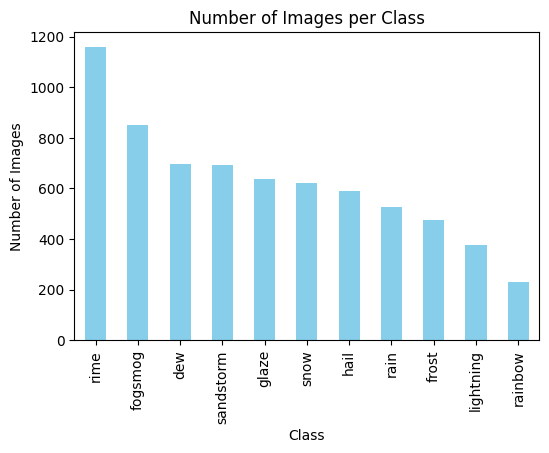

In [11]:
label_counts = df["label"].value_counts()
print(label_counts)
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Images per Class')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

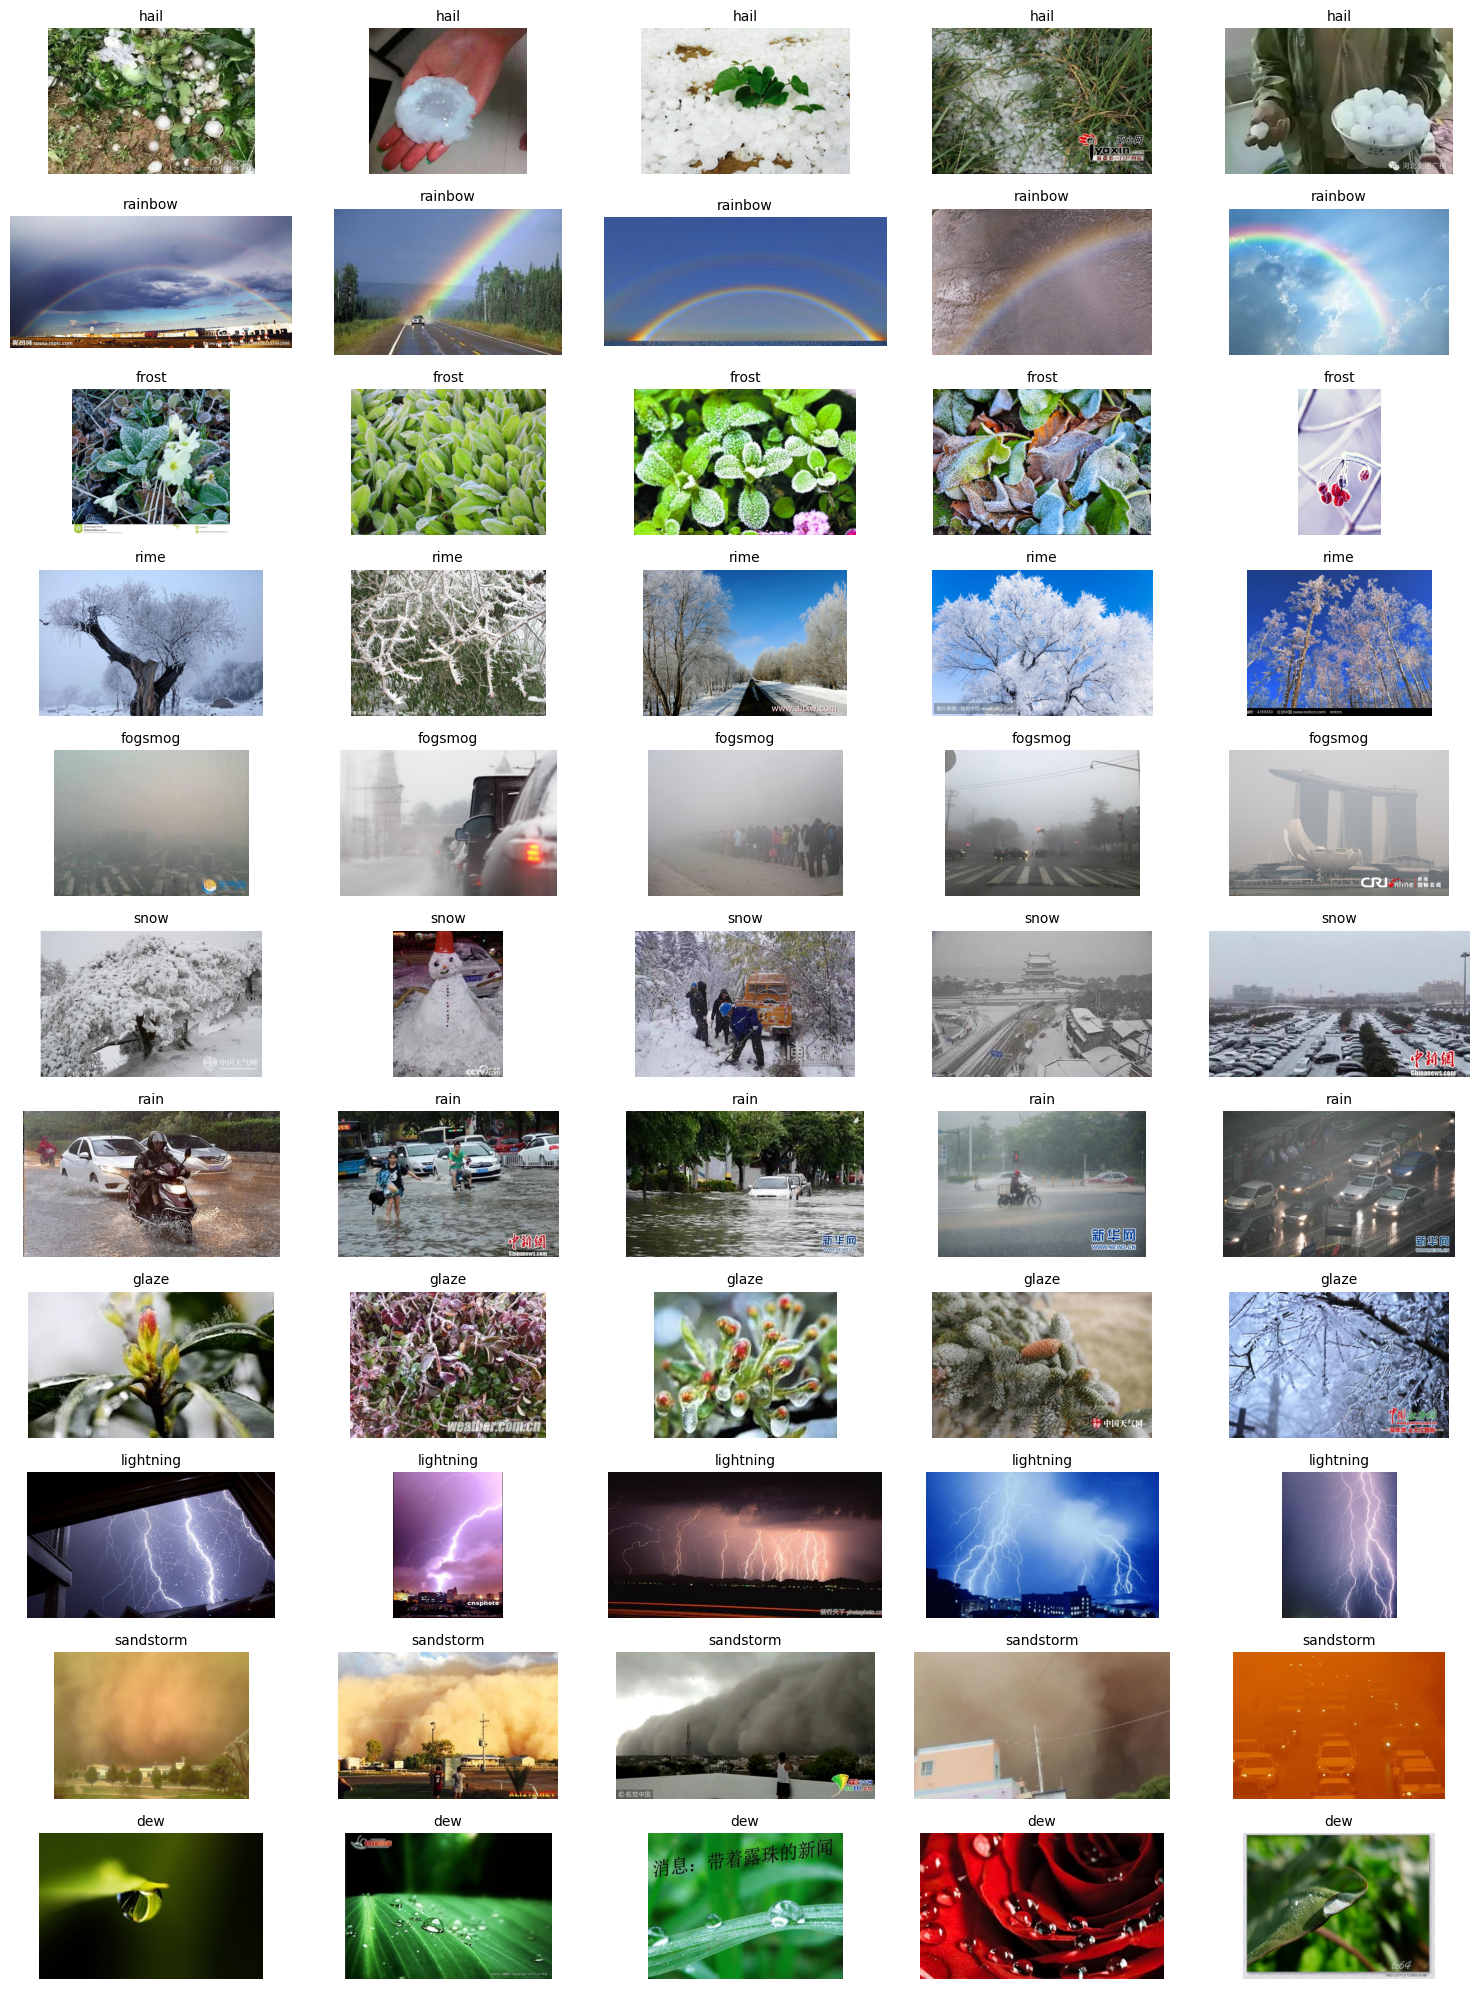

In [12]:
num_samples = 5
plt.figure(figsize=(15, 20))

for class_idx, label in enumerate(df["label"].unique()):
    sample_images = df[df["label"] == label].sample(n=num_samples)
    for i, row in enumerate(sample_images.itertuples()):
        img = plt.imread(row.url)
        ax = plt.subplot(len(df["label"].unique()), num_samples, class_idx * num_samples + i + 1)
        plt.imshow(img)
        plt.title(f"{row.label}", fontsize=10)
        plt.axis("off")
plt.tight_layout()
plt.show()

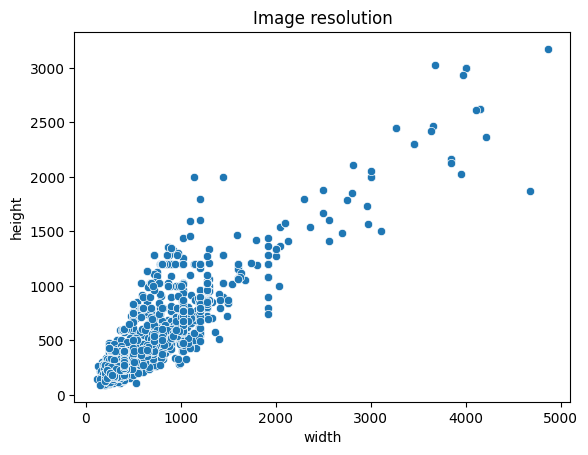

In [13]:
sns.scatterplot(x = "width", y = "height", data = df)
plt.title("Image resolution")

plt.xlabel("width")
plt.ylabel("height")

plt.show()

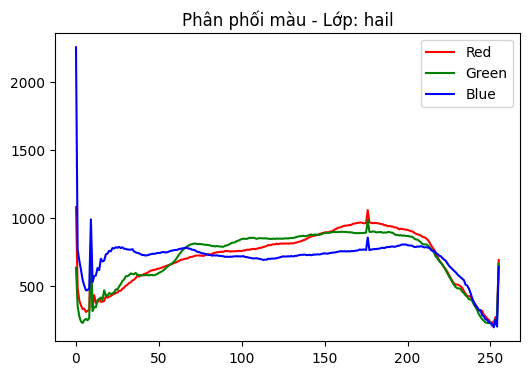

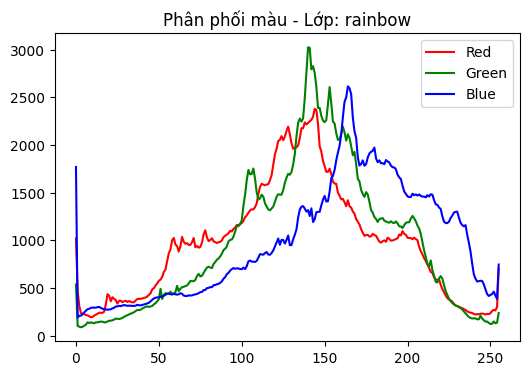

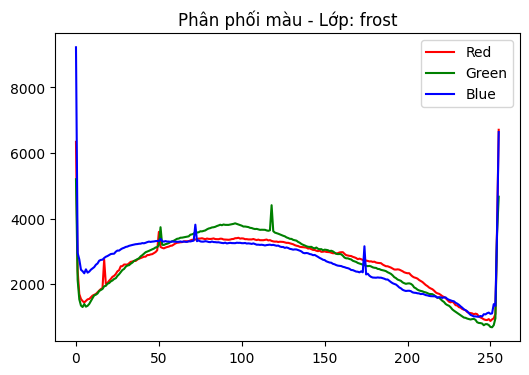

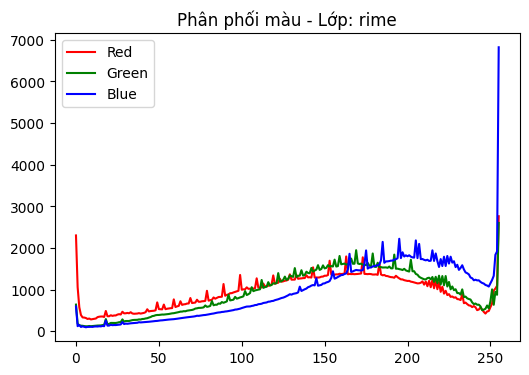

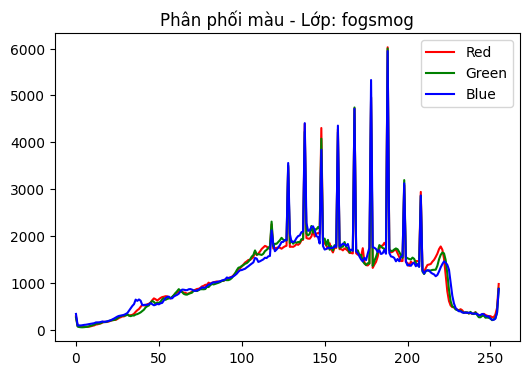

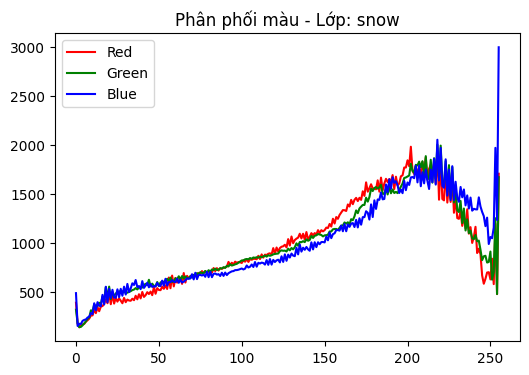

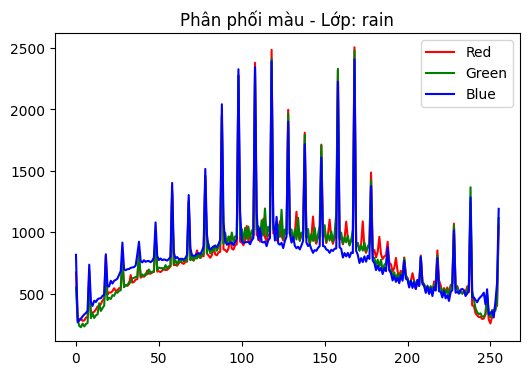

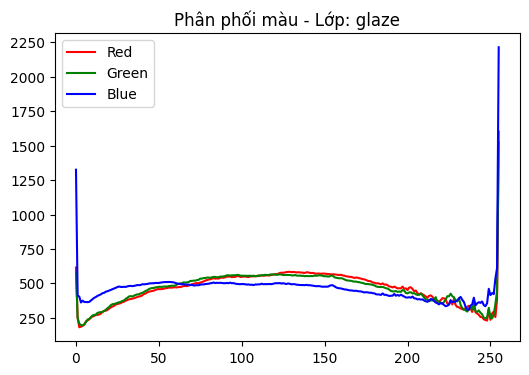

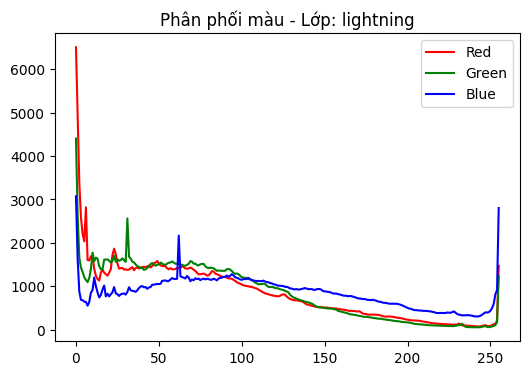

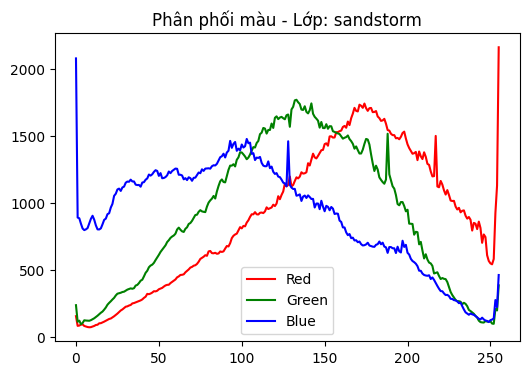

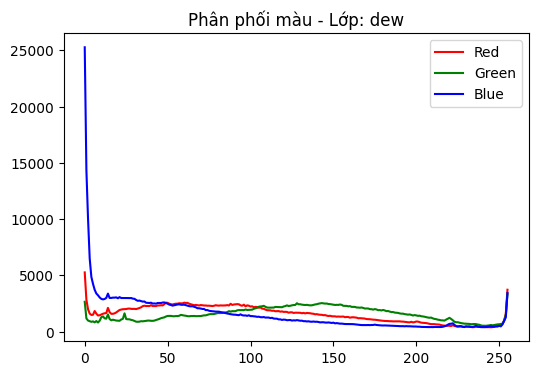

In [14]:
# Danh sách lớp (mỗi thư mục con là 1 lớp)
classes = os.listdir(data_path)

# Lưu histogram trung bình của mỗi lớp
hist_by_class = {cls: {'b': None, 'g': None, 'r': None} for cls in classes}

# Duyệt từng lớp
for cls in classes:
    class_path = os.path.join(data_path, cls)
    b_hist_list, g_hist_list, r_hist_list = [], [], []

    # Duyệt từng ảnh trong lớp
    for file in os.listdir(class_path):
        if not file.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue
        img_path = os.path.join(class_path, file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        # Tính histogram cho từng kênh
        b_hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        g_hist = cv2.calcHist([img], [1], None, [256], [0, 256])
        r_hist = cv2.calcHist([img], [2], None, [256], [0, 256])

        b_hist_list.append(b_hist)
        g_hist_list.append(g_hist)
        r_hist_list.append(r_hist)

    # Trung bình histogram trong lớp
    hist_by_class[cls]['b'] = np.mean(b_hist_list, axis=0)
    hist_by_class[cls]['g'] = np.mean(g_hist_list, axis=0)
    hist_by_class[cls]['r'] = np.mean(r_hist_list, axis=0)

# Vẽ biểu đồ
for cls in classes:
    plt.figure(figsize=(6,4))
    plt.title(f'Phân phối màu - Lớp: {cls}')
    plt.plot(hist_by_class[cls]['r'], color='r', label='Red')
    plt.plot(hist_by_class[cls]['g'], color='g', label='Green')
    plt.plot(hist_by_class[cls]['b'], color='b', label='Blue')
    plt.legend()
    plt.show()

# Feature extraction

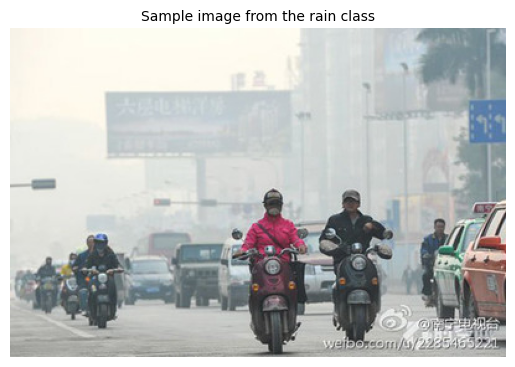

In [15]:
sample_class = "rain"
sample_img_url = df[df["label"] == sample_class].sample(1)["url"]

sample_img = cv2.imread(sample_img_url.values[0])
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.title(f"Sample image from the {sample_class} class", fontsize=10)
plt.axis("off")
plt.show()

In [16]:
model = EfficientNetB3(include_top= False,
                       weights= "imagenet",
                       input_shape= img_shape,
                       pooling= 'max')
def extract_features_imgnet(img_path):
    target_size = (300, 300)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    x = np.array(img, dtype=np.float32)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x, verbose=0)
    return features.flatten()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Extract features using the 3 imported models

def extract_features_dinov2(img_path):
    # ngl [:, :, ::-1] is quite cryptic
    img = cv2.imread(img_path)[:, :, ::-1]
    inputs = dinov2_processor(images=img, return_tensors="pt")
    with torch.no_grad():
        outputs = dinov2_model(**inputs)
    # outputs.last_hidden_state[:, 0, :] is the CLS token embedding
    return outputs.last_hidden_state[:, 0, :].cpu().numpy().flatten()

def extract_features_swin(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = T(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feats = swin_model(img)
    return feats.cpu().numpy().flatten()

def extract_features_deit(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = T(img).unsqueeze(0).to(device)

    with torch.no_grad():
        feats = deit_model(img)
    return feats.cpu().numpy().flatten()

In [18]:
# Test feature extraction
feat = extract_features_imgnet(sample_img_url.values[0])
print("Imgnet feature shape:", feat.shape) # (1536,)

feat = extract_features_dinov2(sample_img_url.values[0])
print("Dinov2 feature shape:", feat.shape) # (384,)

feat = extract_features_swin(sample_img_url.values[0])
print("Swin feature shape:", feat.shape) # (764,)

feat = extract_features_deit(sample_img_url.values[0])
print("Deit feature shape:", feat.shape) # (384,)

Imgnet feature shape: (1536,)
Dinov2 feature shape: (384,)
Swin feature shape: (768,)
Deit feature shape: (384,)


In [19]:
# Compute the feature, looooong
features_imgnet, features_dinov2, features_swin, features_deit, labels = [], [], [], [], []

def make_features():
  # Label only stored if all 4 can extract features
  for label in os.listdir(data_path):
      folder = os.path.join(data_path, label)
      if not os.path.isdir(folder):
          continue
      print(f"📂 Đang xử lý lớp: {label}")
      for file in tqdm(os.listdir(folder)):
          img_path = os.path.join(folder, file)

          noErr = True
          feat_imgnet, feat_dinov2, feat_swin, feat_deit = None, None, None, None

          try:
              feat_imgnet = extract_features_imgnet(img_path)
          except Exception as e:
              print("Lỗi khi xử lý - imgnet", file, ":", e)
              noErr = False

          try:
              feat_dinov2 = extract_features_dinov2(img_path)
          except Exception as e:
              print("Lỗi khi xử lý - dinov2", file, ":", e)
              noErr = False

          try:
              feat_swin = extract_features_swin(img_path)
          except Exception as e:
              print("Lỗi khi xử lý - swin", file, ":", e)
              noErr = False

          try:
              feat_deit = extract_features_deit(img_path)
          except Exception as e:
              print("Lỗi khi xử lý - deit", file, ":", e)
              hasErr = True

          if noErr:
              features_imgnet.append(feat_imgnet)
              features_dinov2.append(feat_dinov2)
              features_swin.append(feat_swin)
              features_deit.append(feat_deit)
              labels.append(label)

# Saving features

In [27]:
%cd etc

/etc


In [29]:
# Check if the files about to save already exist

# Print current path
print("Current path:", os.getcwd())

paths = [
    "features/label.npy",
    "features/efficientnet.npy",
    "features/dinov2.npy",
    "features/swin.npy",
    "features/deit.npy"
]
everyPathsExist = all(os.path.exists(path) for path in paths)
if everyPathsExist:
    print("Features already saved, loading")
    labels = np.load("features/label.npy", allow_pickle=True)
    features_imgnet = np.load("features/efficientnet.npy")
    features_dinov2 = np.load("features/dinov2.npy")
    features_swin = np.load("features/swin.npy")
    features_deit = np.load("features/deit.npy")
    print("Loaded all")
else:
    # check whats NOT saved
    [print(f"{path} doesnt exist") if not os.path.exists(path) else "" for path in paths]

    print("Features not saved, computing")
    make_features()

    # Check if /features exist and create it
    if not os.path.exists("features"):
        os.makedirs("features")

    # Saves the feature
    labels_arr = np.array(labels)
    np.save("features/label.npy", labels_arr)

    features_arr = np.array(features_imgnet)
    np.save("features/efficientnet.npy", features_arr)

    features_arr = np.array(features_dinov2)
    np.save("features/dinov2.npy", features_arr)

    features_arr = np.array(features_swin)
    np.save("features/swin.npy", features_arr)

    features_arr = np.array(features_deit)
    np.save("features/deit.npy", features_arr)

    print("Saved features")

Current path: /etc
Features already saved, loading
Loaded all


# Classification

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [31]:
def report(all_preds,all_labels,label_encoding=None):
    cm = confusion_matrix(all_labels, all_preds)
    classes = label_encoding.classes_ if label_encoding is not None else np.unique(all_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    print("\n Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=classes))

In [32]:
models_list = {
    "SVM":LinearSVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000), #2m
    "Random Forest Regressor, n=50": RandomForestClassifier(n_estimators=50, random_state=42), #30s
    "Random Forest Regressor, n=100": RandomForestClassifier(n_estimators=100, random_state=42), #1m
}

In [ ]:
# data=np.load('features/efficientnet.npy')
# label=np.load('features/label.npy',allow_pickle=True)
# label_encoding=LabelEncoder()
# label=label_encoding.fit_transform(label)

In [43]:
def classify(data, label, dataName):
  X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)
  for name, model in models_list.items():
      print(f"\nTraining model {name} for features from {dataName}")
      model.fit(X_train, y_train)
      all_preds = model.predict(X_test)
      all_labels = y_test
      report(all_preds,all_labels,None)

(6862,)
Num features of model EfficientNet: (6862, 1536)
Num features of model Dinov2: (6862, 384)
Num features of model Swin: (6862, 768)
Num features of model Deit: (6862, 384)
Training model SVM for features from EfficientNet


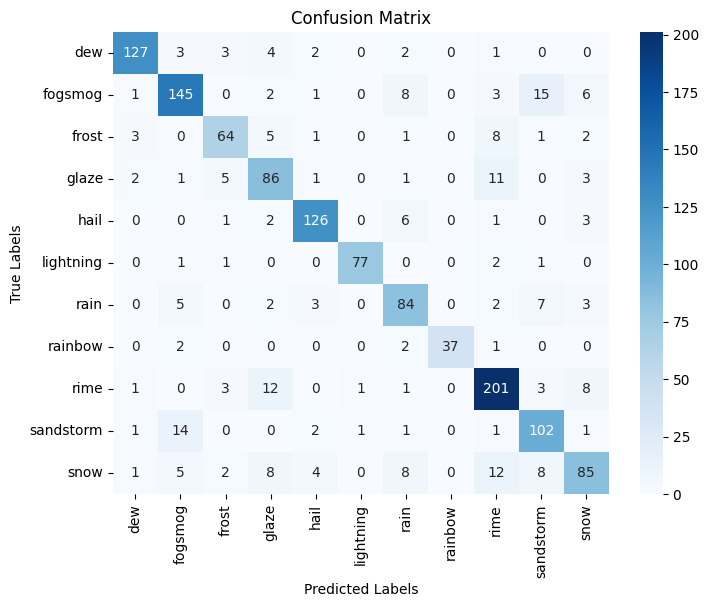


 Classification Report:

              precision    recall  f1-score   support

         dew       0.93      0.89      0.91       142
     fogsmog       0.82      0.80      0.81       181
       frost       0.81      0.75      0.78        85
       glaze       0.71      0.78      0.74       110
        hail       0.90      0.91      0.90       139
   lightning       0.97      0.94      0.96        82
        rain       0.74      0.79      0.76       106
     rainbow       1.00      0.88      0.94        42
        rime       0.83      0.87      0.85       230
   sandstorm       0.74      0.83      0.78       123
        snow       0.77      0.64      0.70       133

    accuracy                           0.83      1373
   macro avg       0.84      0.83      0.83      1373
weighted avg       0.83      0.83      0.83      1373

Training model Logistic Regression for features from EfficientNet


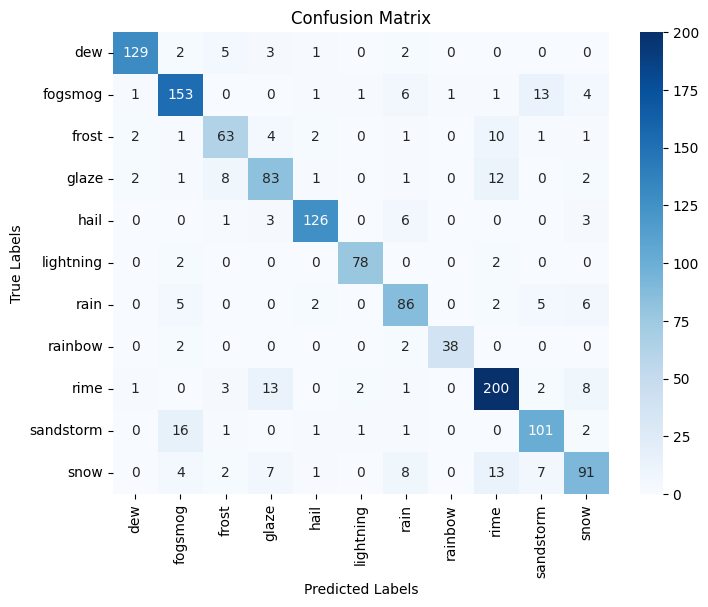


 Classification Report:

              precision    recall  f1-score   support

         dew       0.96      0.91      0.93       142
     fogsmog       0.82      0.85      0.83       181
       frost       0.76      0.74      0.75        85
       glaze       0.73      0.75      0.74       110
        hail       0.93      0.91      0.92       139
   lightning       0.95      0.95      0.95        82
        rain       0.75      0.81      0.78       106
     rainbow       0.97      0.90      0.94        42
        rime       0.83      0.87      0.85       230
   sandstorm       0.78      0.82      0.80       123
        snow       0.78      0.68      0.73       133

    accuracy                           0.84      1373
   macro avg       0.84      0.84      0.84      1373
weighted avg       0.84      0.84      0.84      1373

Training model Random Forest Regressor, n=50 for features from EfficientNet


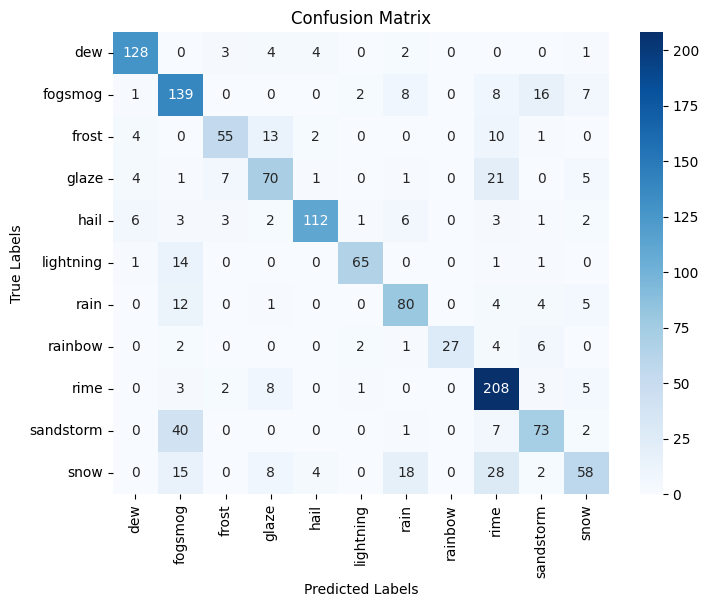


 Classification Report:

              precision    recall  f1-score   support

         dew       0.89      0.90      0.90       142
     fogsmog       0.61      0.77      0.68       181
       frost       0.79      0.65      0.71        85
       glaze       0.66      0.64      0.65       110
        hail       0.91      0.81      0.85       139
   lightning       0.92      0.79      0.85        82
        rain       0.68      0.75      0.72       106
     rainbow       1.00      0.64      0.78        42
        rime       0.71      0.90      0.79       230
   sandstorm       0.68      0.59      0.63       123
        snow       0.68      0.44      0.53       133

    accuracy                           0.74      1373
   macro avg       0.77      0.72      0.74      1373
weighted avg       0.75      0.74      0.74      1373

Training model Random Forest Regressor, n=100 for features from EfficientNet


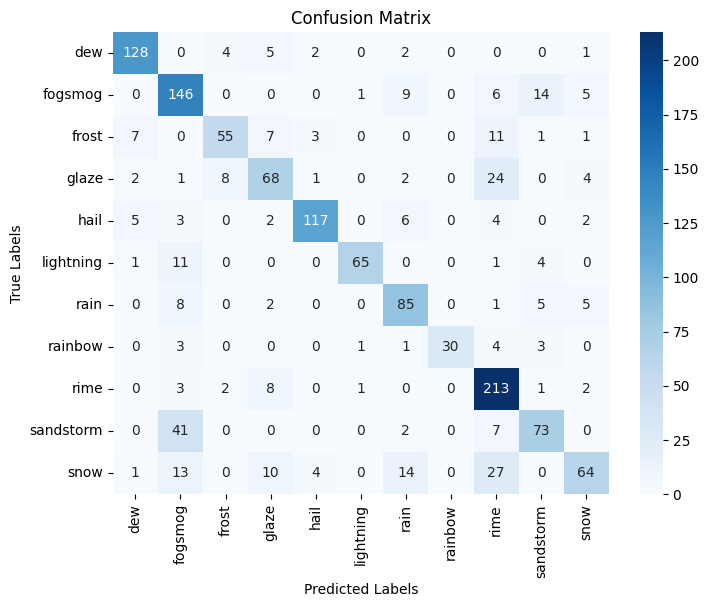


 Classification Report:

              precision    recall  f1-score   support

         dew       0.89      0.90      0.90       142
     fogsmog       0.64      0.81      0.71       181
       frost       0.80      0.65      0.71        85
       glaze       0.67      0.62      0.64       110
        hail       0.92      0.84      0.88       139
   lightning       0.96      0.79      0.87        82
        rain       0.70      0.80      0.75       106
     rainbow       1.00      0.71      0.83        42
        rime       0.71      0.93      0.81       230
   sandstorm       0.72      0.59      0.65       123
        snow       0.76      0.48      0.59       133

    accuracy                           0.76      1373
   macro avg       0.80      0.74      0.76      1373
weighted avg       0.77      0.76      0.76      1373

Training model SVM for features from Dinov2


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


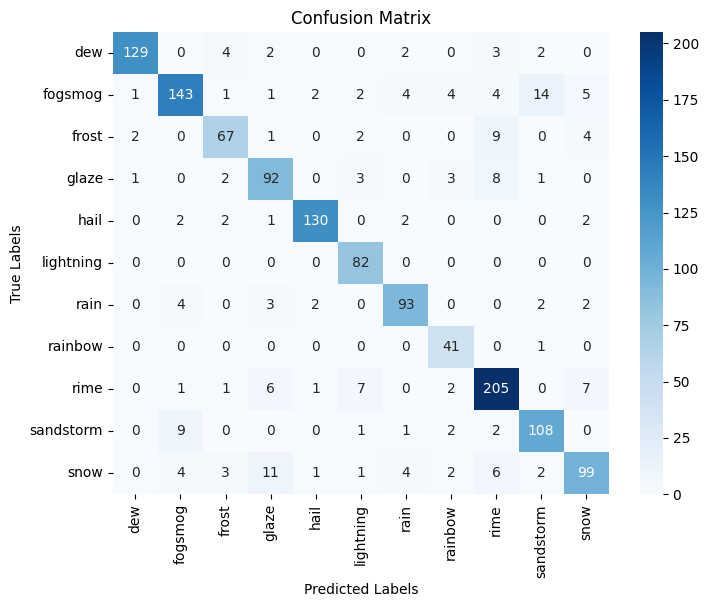


 Classification Report:

              precision    recall  f1-score   support

         dew       0.97      0.91      0.94       142
     fogsmog       0.88      0.79      0.83       181
       frost       0.84      0.79      0.81        85
       glaze       0.79      0.84      0.81       110
        hail       0.96      0.94      0.95       139
   lightning       0.84      1.00      0.91        82
        rain       0.88      0.88      0.88       106
     rainbow       0.76      0.98      0.85        42
        rime       0.86      0.89      0.88       230
   sandstorm       0.83      0.88      0.85       123
        snow       0.83      0.74      0.79       133

    accuracy                           0.87      1373
   macro avg       0.86      0.88      0.86      1373
weighted avg       0.87      0.87      0.87      1373

Training model Logistic Regression for features from Dinov2


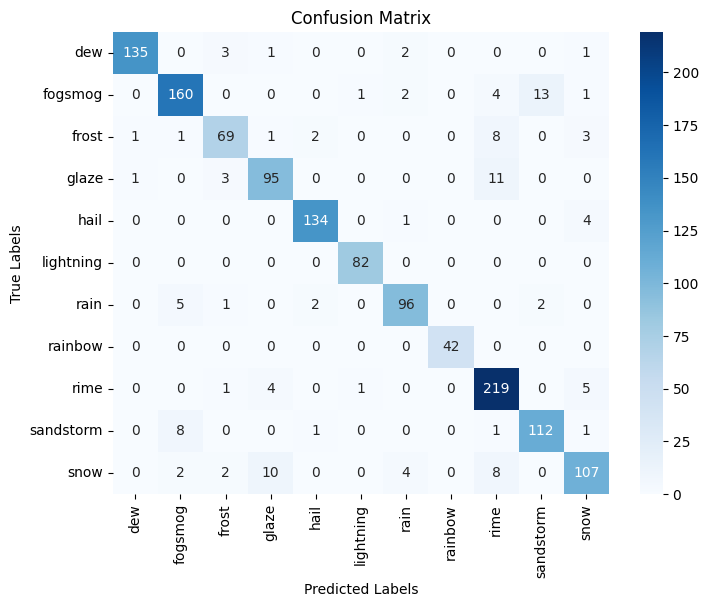


 Classification Report:

              precision    recall  f1-score   support

         dew       0.99      0.95      0.97       142
     fogsmog       0.91      0.88      0.90       181
       frost       0.87      0.81      0.84        85
       glaze       0.86      0.86      0.86       110
        hail       0.96      0.96      0.96       139
   lightning       0.98      1.00      0.99        82
        rain       0.91      0.91      0.91       106
     rainbow       1.00      1.00      1.00        42
        rime       0.87      0.95      0.91       230
   sandstorm       0.88      0.91      0.90       123
        snow       0.88      0.80      0.84       133

    accuracy                           0.91      1373
   macro avg       0.92      0.91      0.92      1373
weighted avg       0.91      0.91      0.91      1373

Training model Random Forest Regressor, n=50 for features from Dinov2


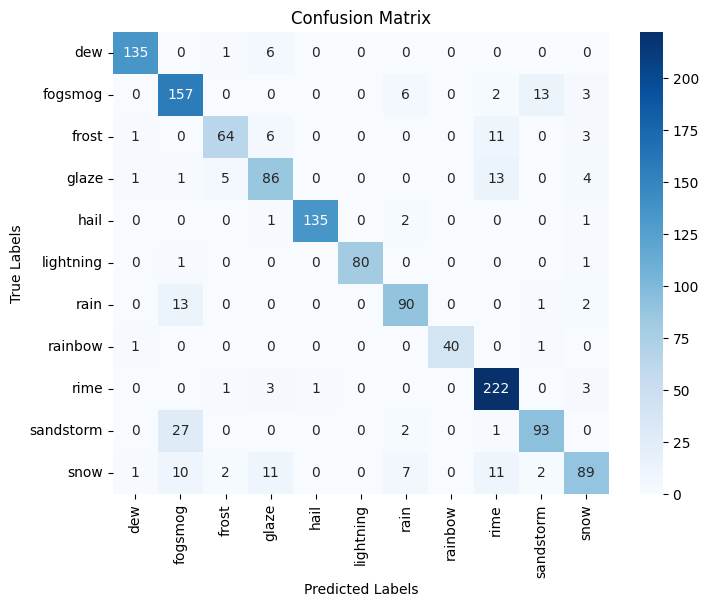


 Classification Report:

              precision    recall  f1-score   support

         dew       0.97      0.95      0.96       142
     fogsmog       0.75      0.87      0.81       181
       frost       0.88      0.75      0.81        85
       glaze       0.76      0.78      0.77       110
        hail       0.99      0.97      0.98       139
   lightning       1.00      0.98      0.99        82
        rain       0.84      0.85      0.85       106
     rainbow       1.00      0.95      0.98        42
        rime       0.85      0.97      0.91       230
   sandstorm       0.85      0.76      0.80       123
        snow       0.84      0.67      0.74       133

    accuracy                           0.87      1373
   macro avg       0.88      0.86      0.87      1373
weighted avg       0.87      0.87      0.87      1373

Training model Random Forest Regressor, n=100 for features from Dinov2


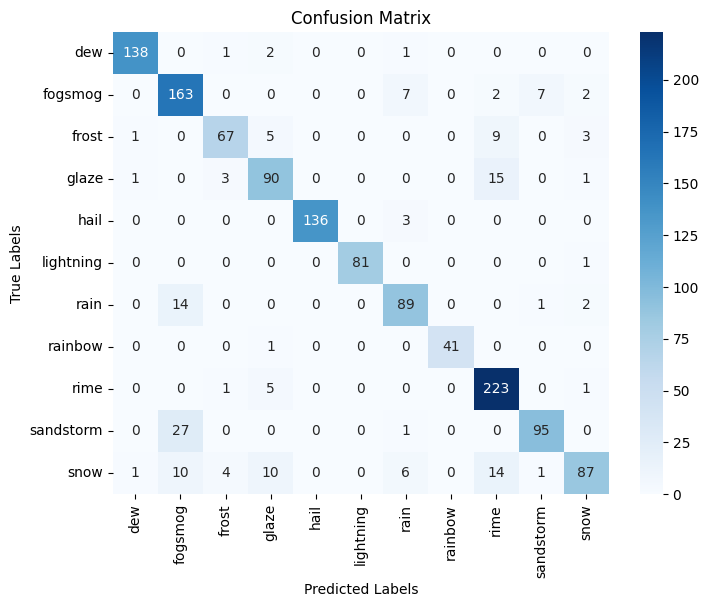


 Classification Report:

              precision    recall  f1-score   support

         dew       0.98      0.97      0.98       142
     fogsmog       0.76      0.90      0.83       181
       frost       0.88      0.79      0.83        85
       glaze       0.80      0.82      0.81       110
        hail       1.00      0.98      0.99       139
   lightning       1.00      0.99      0.99        82
        rain       0.83      0.84      0.84       106
     rainbow       1.00      0.98      0.99        42
        rime       0.85      0.97      0.90       230
   sandstorm       0.91      0.77      0.84       123
        snow       0.90      0.65      0.76       133

    accuracy                           0.88      1373
   macro avg       0.90      0.88      0.89      1373
weighted avg       0.89      0.88      0.88      1373

Training model SVM for features from Swin


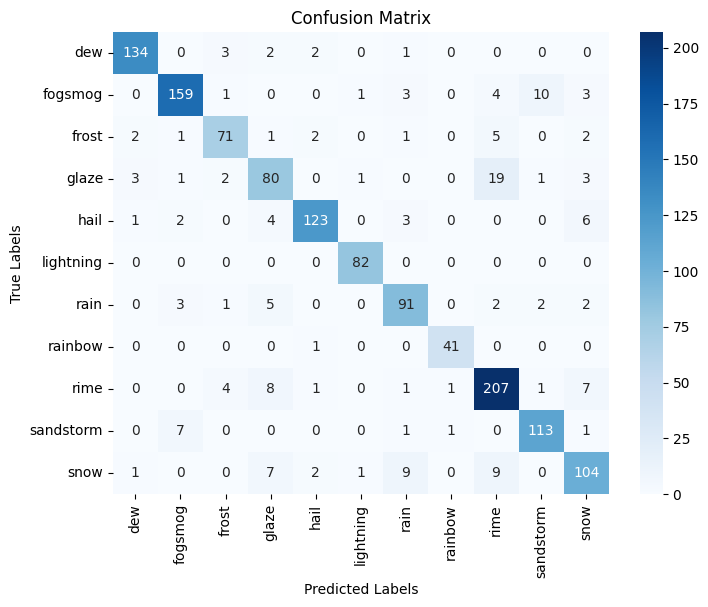


 Classification Report:

              precision    recall  f1-score   support

         dew       0.95      0.94      0.95       142
     fogsmog       0.92      0.88      0.90       181
       frost       0.87      0.84      0.85        85
       glaze       0.75      0.73      0.74       110
        hail       0.94      0.88      0.91       139
   lightning       0.96      1.00      0.98        82
        rain       0.83      0.86      0.84       106
     rainbow       0.95      0.98      0.96        42
        rime       0.84      0.90      0.87       230
   sandstorm       0.89      0.92      0.90       123
        snow       0.81      0.78      0.80       133

    accuracy                           0.88      1373
   macro avg       0.88      0.88      0.88      1373
weighted avg       0.88      0.88      0.88      1373

Training model Logistic Regression for features from Swin


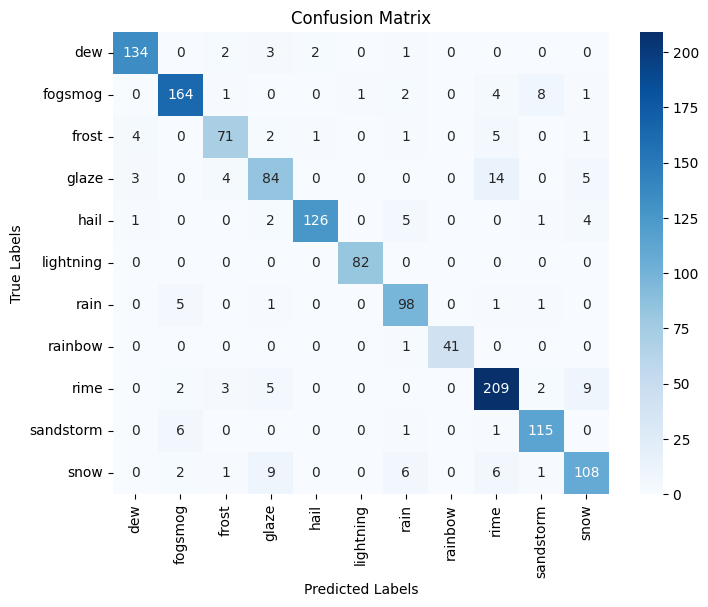


 Classification Report:

              precision    recall  f1-score   support

         dew       0.94      0.94      0.94       142
     fogsmog       0.92      0.91      0.91       181
       frost       0.87      0.84      0.85        85
       glaze       0.79      0.76      0.78       110
        hail       0.98      0.91      0.94       139
   lightning       0.99      1.00      0.99        82
        rain       0.85      0.92      0.89       106
     rainbow       1.00      0.98      0.99        42
        rime       0.87      0.91      0.89       230
   sandstorm       0.90      0.93      0.92       123
        snow       0.84      0.81      0.83       133

    accuracy                           0.90      1373
   macro avg       0.90      0.90      0.90      1373
weighted avg       0.90      0.90      0.90      1373

Training model Random Forest Regressor, n=50 for features from Swin


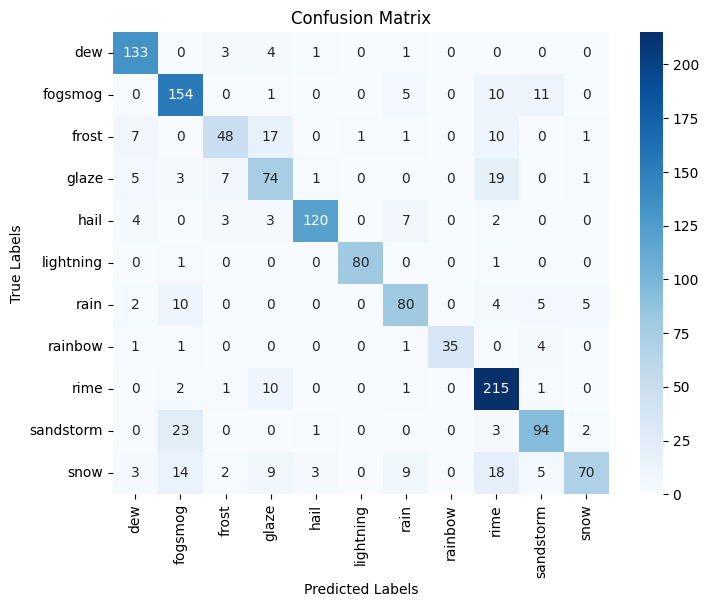


 Classification Report:

              precision    recall  f1-score   support

         dew       0.86      0.94      0.90       142
     fogsmog       0.74      0.85      0.79       181
       frost       0.75      0.56      0.64        85
       glaze       0.63      0.67      0.65       110
        hail       0.95      0.86      0.91       139
   lightning       0.99      0.98      0.98        82
        rain       0.76      0.75      0.76       106
     rainbow       1.00      0.83      0.91        42
        rime       0.76      0.93      0.84       230
   sandstorm       0.78      0.76      0.77       123
        snow       0.89      0.53      0.66       133

    accuracy                           0.80      1373
   macro avg       0.83      0.79      0.80      1373
weighted avg       0.81      0.80      0.80      1373

Training model Random Forest Regressor, n=100 for features from Swin


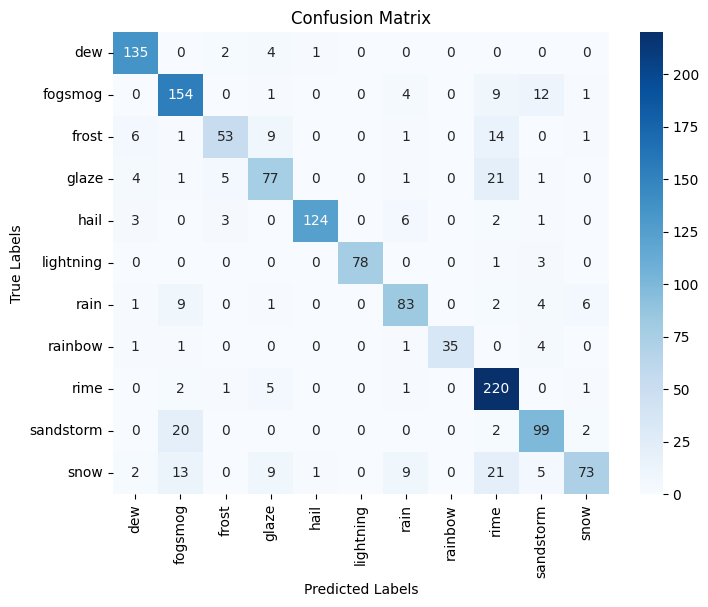


 Classification Report:

              precision    recall  f1-score   support

         dew       0.89      0.95      0.92       142
     fogsmog       0.77      0.85      0.81       181
       frost       0.83      0.62      0.71        85
       glaze       0.73      0.70      0.71       110
        hail       0.98      0.89      0.94       139
   lightning       1.00      0.95      0.97        82
        rain       0.78      0.78      0.78       106
     rainbow       1.00      0.83      0.91        42
        rime       0.75      0.96      0.84       230
   sandstorm       0.77      0.80      0.79       123
        snow       0.87      0.55      0.67       133

    accuracy                           0.82      1373
   macro avg       0.85      0.81      0.82      1373
weighted avg       0.83      0.82      0.82      1373

Training model SVM for features from Deit


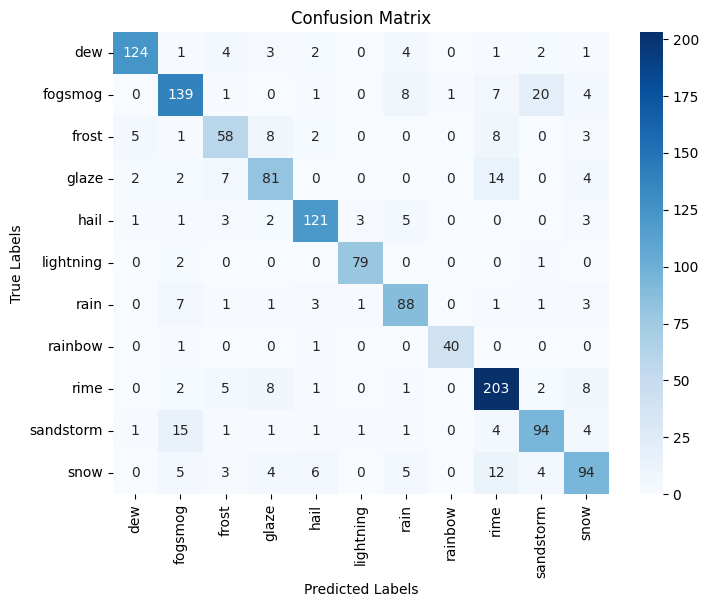


 Classification Report:

              precision    recall  f1-score   support

         dew       0.93      0.87      0.90       142
     fogsmog       0.79      0.77      0.78       181
       frost       0.70      0.68      0.69        85
       glaze       0.75      0.74      0.74       110
        hail       0.88      0.87      0.87       139
   lightning       0.94      0.96      0.95        82
        rain       0.79      0.83      0.81       106
     rainbow       0.98      0.95      0.96        42
        rime       0.81      0.88      0.85       230
   sandstorm       0.76      0.76      0.76       123
        snow       0.76      0.71      0.73       133

    accuracy                           0.82      1373
   macro avg       0.83      0.82      0.82      1373
weighted avg       0.82      0.82      0.82      1373

Training model Logistic Regression for features from Deit


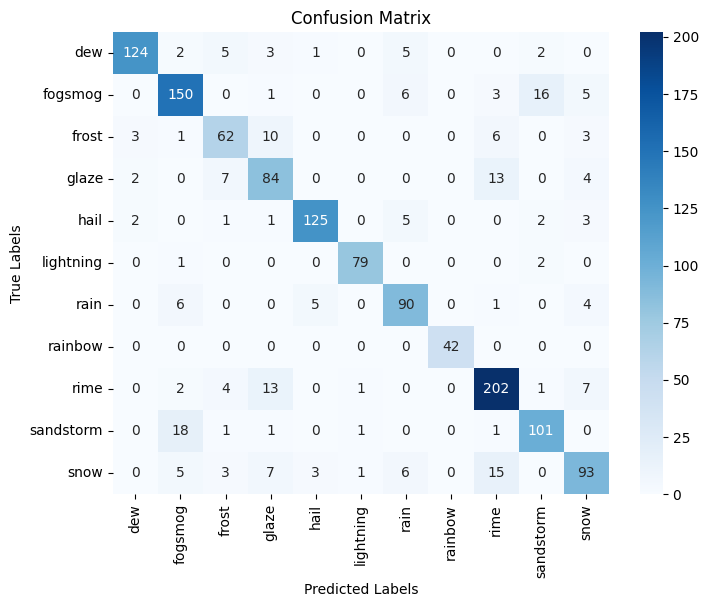


 Classification Report:

              precision    recall  f1-score   support

         dew       0.95      0.87      0.91       142
     fogsmog       0.81      0.83      0.82       181
       frost       0.75      0.73      0.74        85
       glaze       0.70      0.76      0.73       110
        hail       0.93      0.90      0.92       139
   lightning       0.96      0.96      0.96        82
        rain       0.80      0.85      0.83       106
     rainbow       1.00      1.00      1.00        42
        rime       0.84      0.88      0.86       230
   sandstorm       0.81      0.82      0.82       123
        snow       0.78      0.70      0.74       133

    accuracy                           0.84      1373
   macro avg       0.85      0.85      0.85      1373
weighted avg       0.84      0.84      0.84      1373

Training model Random Forest Regressor, n=50 for features from Deit


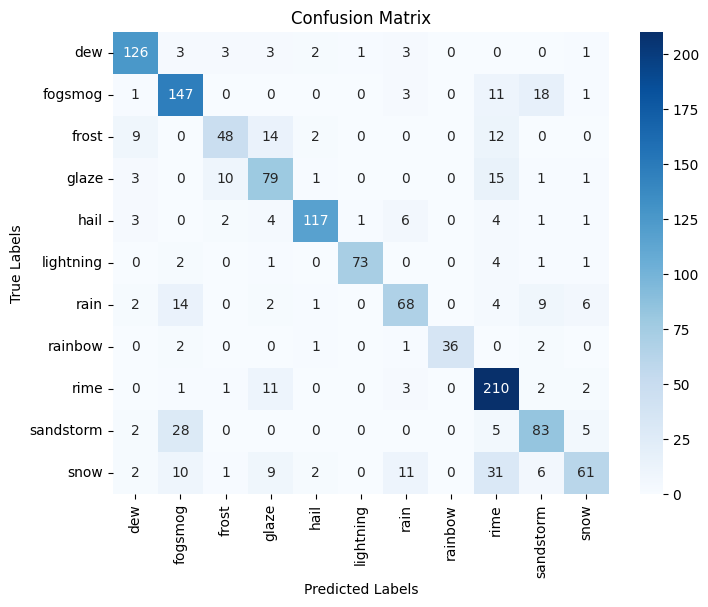


 Classification Report:

              precision    recall  f1-score   support

         dew       0.85      0.89      0.87       142
     fogsmog       0.71      0.81      0.76       181
       frost       0.74      0.56      0.64        85
       glaze       0.64      0.72      0.68       110
        hail       0.93      0.84      0.88       139
   lightning       0.97      0.89      0.93        82
        rain       0.72      0.64      0.68       106
     rainbow       1.00      0.86      0.92        42
        rime       0.71      0.91      0.80       230
   sandstorm       0.67      0.67      0.67       123
        snow       0.77      0.46      0.58       133

    accuracy                           0.76      1373
   macro avg       0.79      0.75      0.76      1373
weighted avg       0.77      0.76      0.76      1373

Training model Random Forest Regressor, n=100 for features from Deit


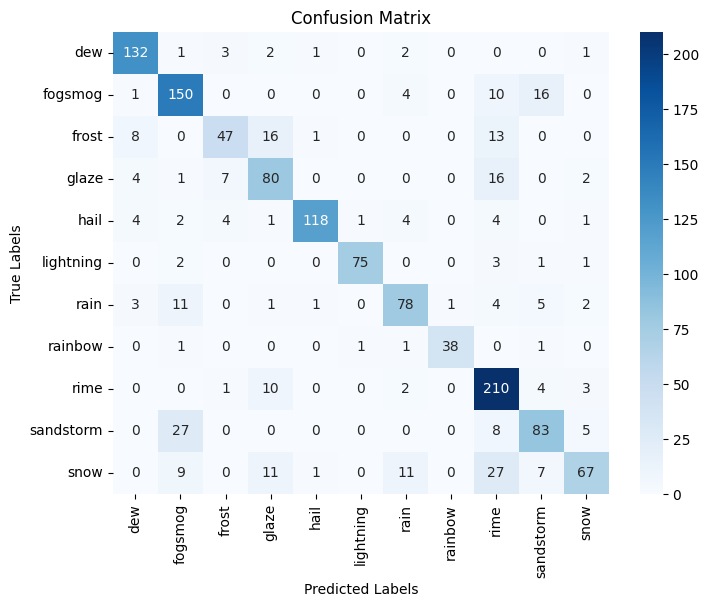


 Classification Report:

              precision    recall  f1-score   support

         dew       0.87      0.93      0.90       142
     fogsmog       0.74      0.83      0.78       181
       frost       0.76      0.55      0.64        85
       glaze       0.66      0.73      0.69       110
        hail       0.97      0.85      0.90       139
   lightning       0.97      0.91      0.94        82
        rain       0.76      0.74      0.75       106
     rainbow       0.97      0.90      0.94        42
        rime       0.71      0.91      0.80       230
   sandstorm       0.71      0.67      0.69       123
        snow       0.82      0.50      0.62       133

    accuracy                           0.79      1373
   macro avg       0.81      0.78      0.79      1373
weighted avg       0.79      0.79      0.78      1373



[None, None, None, None]

In [45]:
data_arr = [
    [features_imgnet, "EfficientNet"],
    [features_dinov2, "Dinov2"],
    [features_swin, "Swin"],
    [features_deit, "Deit"]
]

print(labels.shape)
[print(f"Num features of model {data[1]}: {data[0].shape}") for data in data_arr]
[classify(data[0], labels, data[1]) for data in data_arr]

# Results

## Overview

Total entries: 6,862

Classes: 11 weather phenomena
+ dew
+ fogsmog
+ frost
+ glaze
+ hail
+ lightning
+ rain
+ rainbow
+ rime
+ sandstorm
+ snow

## Pipeline

Each image go through a feature extractor before a classical classifier head.

The extracted features can be found in ```./features``` for all feature exctractors innvolved.

## Feature Extractors

| Model                | Feature Dimension | Description                                          |
| :------------------- | :---------------: | :--------------------------------------------------- |
| **EfficientNet**     |       1,536       | CNN-based, strong baseline for visual features       |
| **DINOv2**           |        384        | Self-supervised ViT, highly semantic features        |
| **Swin Transformer** |        768        | Hierarchical transformer, good spatial understanding |
| **DeiT**             |        384        | Data-efficient Vision Transformer                    |

## Classifier

Each extractor was evaluated with three classical classifiers:

+ SVM (Support Vector Machine)

+ Logistic Regression

+ Random Forest (n=50 and n=100)

## Accuracy Comparison of results

| Feature Extractor |  SVM | Logistic Regression | Random Forest (k = 50) | Random Forest (k = 100) |
| :---------------- | :--: | :-----------------: | :----------------: | :-----------------: |
| **EfficientNet**  | 0.83 |         0.84        |        0.74        |         0.76        |
| **DINOv2**        | 0.87 |       **0.91**      |        0.87        |         0.88        |
| **Swin**          | 0.88 |       **0.90**      |        0.80        |         0.82        |
| **DeiT**          | 0.82 |         0.84        |        0.76        |         0.79        |


## Best Performing Configuration

| Extractor        | Classifier              | Accuracy | Macro F1 | Weighted F1 | Notes                                                      |
| :--------------- | :---------------------- | :------- | :------- | :---------- | :--------------------------------------------------------- |
| **DINOv2**       | **Logistic Regression** | **0.91** | 0.92     | 0.91        | Excellent balance of recall & precision across all classes |
| **Swin**         | Logistic Regression     | 0.90     | 0.90     | 0.90        | Competitive transformer, strong generalization             |
| **DINOv2**       | Random Forest (100)     | 0.88     | 0.89     | 0.88        | Very stable results                                        |
| **EfficientNet** | Logistic Regression     | 0.84     | 0.84     | 0.84        | Best CNN-based baseline                                    |
| **DeiT**         | Logistic Regression     | 0.84     | 0.85     | 0.84        | Consistent but slightly weaker than DINOv2/Swin            |

## Notes about the performance

### CNN Extractor (EfficientNet)

1. EfficientNet provides solid baseline results.

2. The model performs best with Logistic Regression.

3. The model have slightly lower accuracy than Transformer-based extractors, reflecting the representational advantage of ViT-style (Vision Transformer) features.

### Transformer-Based Extractors (DINOv2, Swin, DeiT)

1. **DINOv2**: Shows the best overall performance, benefiting from strong semantic self-supervised embeddings.

2. **Swin**: Performs very closely to **DINOv2**, slightly behind in macro F1 but strong in consistent class recall.

3. **DeiT**: Offers competitive results with smaller feature vectors, suggesting better efficiency for moderate datasets.

### Random Forests

+ Random forests accuracy improves modestly from 50 → 100 estimators (which may indicates we have not hit the "dilution" threshold yet). But remains ~10% lower than SVM or Logistic Regression on average.

+ Random forests tends to have higher recall for frequent classes - i.e more representation in the data (e.g., rime, fogsmog) but gradually lower precision for smaller classes (snow, rainbow).

### Overall notes:

+ DINOv2 + Logistic Regression head gives the highest accuracy (91%) and macro F1 (0.92).

+ Swin + Logistic Regression head is a very close second (90% accuracy). More test data is required to indicate which one ended up generalized the data better.

+ Random Forest models are less effective for these feature dimensions. Which may indicate normal splitting based question strategy do not capture the intricacies of the higher-dimensional embedding so well.

+ SVM and Logistic Regression handle high-dimensional embeddings efficiently and generalize better. Logistic Regression is especially note-worthy since it performs well inndicates the data becomes linear in this new high dimension.

+ Transformer-based features outperform CNN-based ones for diverse visual weather conditions. This highlighting the power of self-supervised and hierarchical attention mechanisms to embed the data for this task - classifying whether phenomenons.

## Summary of top 5 Feature extractor + Head Results
| Extractor        | Classifier              | Accuracy | Macro F1 | Weighted F1 | Notes                                                      |
| :--------------- | :---------------------- | :------- | :------- | :---------- | :--------------------------------------------------------- |
| **DINOv2**       | **Logistic Regression** | **0.91** | 0.92     | 0.91        | Excellent balance of recall & precision across all classes |
| **Swin**         | Logistic Regression     | 0.90     | 0.90     | 0.90        | Competitive transformer, strong generalization             |
| **DINOv2**       | Random Forest (100)     | 0.88     | 0.89     | 0.88        | Very stable results                                        |
| **EfficientNet** | Logistic Regression     | 0.84     | 0.84     | 0.84        | Best CNN-based baseline                                    |
| **DeiT**         | Logistic Regression     | 0.84     | 0.85     | 0.84        | Consistent but slightly weaker than DINOv2/Swin            |